In [ ]:
%pip install gymnasium
%pip install stable_baselines3
%pip install stable_baselines


In [ ]:
%pip install keras
%pip install optuna


In [ ]:
%pip install --upgrade pip

In [11]:
import gym
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np
from gym_anytrading.envs import StocksEnv
import gym_anytrading
import quantstats as qs
import pandas as pd
import matplotlib.pyplot as plt
import logging
import optuna



In [12]:
logger = logging.getLogger('training')
logger.setLevel(logging.INFO)

file_handler = logging.FileHandler('training.log')
formatter = logging.Formatter('%(asctime)s - %(message)s')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

In [31]:
import yfinance as yf
vgt_data = yf.download("VGT", period = '5y')
schd_data = yf.download("SCHD", period = '5y')
voo_data = yf.download('VOO', period = '5y')
data = pd.concat([vgt_data, schd_data, voo_data]) 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [37]:
#Rolling window split. Two year training data

train_df = data[:2*365]
val_df_1 = data[2*365:3*365]
val_df_2 = data[3*365:4*365]
val_df_3 = data[4*365:5*365]

In [46]:
def ModelCreation():

    #Creating Logging env
    logger = logging.getLogger('training')
    logger.setLevel(logging.INFO)

    file_handler = logging.FileHandler('training.log')
    formatter = logging.Formatter('%(asctime)s - %(message)s')
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)

    #Creating training env

    window_size = 10
    start_index = window_size
    end_index = len(data)

    train_env = gym.make(
            'stocks-v0',
            df = train_df,
            window_size = window_size,
            frame_bound = (start_index, end_index)
        )

    val_env1 = gym.make(
        'stocks-v0',
        df = val_df_1,
        window_size = window_size,
        frame_bound = (start_index, end_index)
    )




    val_env2 = gym.make(
        'stocks-v0',
        df = val_df_2,
        window_size = window_size,
        frame_bound = (start_index, end_index)
    )



    val_env3 = gym.make(
        'stocks-v0',
        df = val_df_3,
        window_size = window_size,
        frame_bound = (start_index, end_index)
    )

    env1 = DummyVecEnv([lambda : train_env, lambda : val_env1, lambda : val_env2, lambda : val_env3])

    #Setting up hyperparameter tuners

    def optimizePPO(trial):
        return {
            'n_steps' : int(trial.suggest_loguniform('n_steps', 16, 2048)),
            'gamma' : trial.suggest_loguniform('gamma', 0.9, 0.9999),
            'learning_rate' : trial.suggest_loguniform('learning_rate', 1e-5, 1.),
            'ent_coef' : trial.suggest_loguniform('ent_coef', 1e-8, 1e-1),
            'clip_range': trial.suggest_uniform('clip_range', 0.1, 0.4),
            'n_epochs' : int(trial.suggest_loguniform('n_epochs', 1, 48)),
            'gae_lambda': trial.suggest_uniform('gae_lambda', 0.8, 1.)
        }

    def OptimizeA2C(trial):

        return {
            'n_steps': trial.suggest_int('n_steps', 16, 2048),
            'gamma': trial.suggest_uniform('gamma', 0.9, 0.9999),
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1.),
            'ent_coef': trial.suggest_loguniform('ent_coef', 1e-8, 1e-1),
            'vf_coef': trial.suggest_loguniform('vf_coef', 0.5, 1.) 
        }

    file_handler.close()
    logger.removeHandler(file_handler)

    file_handler = logging.FileHandler('training.log')
    logger.addHandler(file_handler)


    logger.info('Starting Hyperparameter Tuning...')

    
    def Optimize_PPO_agent(trial):
        model_params = optimizePPO(trial)
        env = env1
        model = PPO('MlpPolicy', train_env, verbose=1, **model_params)
        model.learn(10000)

        rewards = []
        global n_steps
        n_steps = 0

        n_episodes, reward_sum = 0, 0.0

        obs = env.reset()
        while n_episodes < 4:
            action, _ = model.predict(obs)
            obs, reward, done, _ = env.step(action)
            reward_sum += reward

            if done.all():
                rewards.append(reward_sum)
                reward_sum = 0.0
                n_episodes += 1
                obs = env.reset()

        last_reward = np.mean(rewards)
        trial.report(-1 * last_reward, step = n_steps)

        return -1 * last_reward

    def Optimize_A2C_agent(trial):
        model_params = OptimizeA2C(trial)
        env = env1
        model = A2C('MlpPolicy', train_env, verbose=1, **model_params)
        model.learn(10000)

        rewards = []
        global n_steps
        n_steps = 0

        n_episodes, reward_sum = 0, 0.0

        obs = env.reset()
        while n_episodes < 4:
            action, _ = model.predict(obs)
            obs, reward, done, _ = env.step(action)
            reward_sum += reward

            if done.all():
                rewards.append(reward_sum)
                reward_sum = 0.0
                n_episodes += 1
                obs = env.reset()

        last_reward = np.mean(rewards)
        trial.report(-1 * last_reward, step = n_steps)

        return -1 * last_reward


    ppo_study = optuna.create_study()
    ppo_study.optimize(Optimize_PPO_agent, n_trials = 3)

    a2c_study = optuna.create_study()
    a2c_study.optimize(Optimize_A2C_agent, n_trials = 3)

    ppo_best_params = ppo_study.best_params
    ppo_best_params['clip_range'] = float(ppo_best_params['clip_range'])
    ppo_best_params['n_steps'] = int(ppo_best_params['n_steps'])
    ppo_best_params['n_epochs'] = int(ppo_best_params['n_epochs'])
    
    a2c_best_params = a2c_study.best_params

    logger.info(f'Hyperparameter tuning is complete. The A2C best parameters are: {a2c_best_params} and the best PPO parameters are: {ppo_best_params}')

    logger.info('Initializing the PPO and A2C models...')
    ppo_agent = PPO('MlpPolicy', train_env, verbose=1, **ppo_best_params)
    a2c_agent = A2C('MlpPolicy', train_env, verbose=1, **a2c_best_params)

    logger.info('Training the PPO Agent...')
    ppo_agent.learn(total_timesteps=10000)

    logger.info('Training the A2C Agent...')
    a2c_agent.learn(total_timesteps=10000)

    logger.info('Training is complete')


    envs = [val_env1, val_env2, val_env3]

    def evalModel():

        num_years = 3
        counter = 3

        while counter <= num_years:

            for i in envs:
                ppo_rewards = []
                obs1 = i.reset()

                while True:
                    action, _ = ppo_agent.predict(obs1)
                    logger.info(f'PPO Took action {action} in state {obs1}')
                    obs, reward, done, info = i.step(action)
                    ppo_rewards.append(reward)

                    if done:
                        break

                print(f'PPO average validation for year {counter} reward: ', np.mean(ppo_rewards))


                a2c_rewards = []
                obs2 = val_env1.reset()

                while True:
                    action, _ = a2c_agent.predict(obs2)
                    obs, reward, done, info = val_env1.step(action)
                    a2c_rewards.append(reward)

                    if done:
                        break

                print(f'A2C average validation for year {counter} reward: ', np.mean(a2c_rewards))

                if np.mean(ppo_rewards) > np.mean(a2c_rewards):
                    agent = ppo_agent
                    action, _ = agent.predict(obs1)
                    print(f'Agent chosen for year {counter} is PPO')
                else:
                    agent = a2c_agent
                    action, _ = agent.predict(obs2)
                    print(f'Agent chosen for year {counter} is A2C')

                counter += 1

                ppo_val = ppo_rewards
                a2c_val = a2c_rewards

                #.bar(np.arange(len(ppo_val)), ppo_val, label = 'PPO')
                #.bar(np.arange(len(a2c_val)), a2c_val, label = 'A2C')
                #.xlabel(f'Validation Performance for year {counter}')
                #.ylabel('Average Reward')
                #.legend()
                #.show()

        



        print("info:", info)
        plt.plot(ppo_rewards, label = 'PPO')
        plt.plot(a2c_rewards, label = 'A2C')

        plt.legend()
        plt.title('Agent Rewards')
        plt.show()



    evalModel()


    




C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\utils\passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (10, 2)
  logger.warn(
C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
[I 2023-08-03 19:57:49,135] A new study created in memory with name: no-name-cd57e2f7-4f00-4961-a970-

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 1918 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 716  |
-----------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 719          |
|    ep_rew_mean          | 90.6         |
| time/                   |              |
|    fps                  | 1047         |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 1432         |
| train/                  |              |
|    approx_kl            | 0.0011160992 |
|    clip_fraction        | 0            |
|    clip_range           | 0.297        |
|    entropy_loss         | -0.693       |
|    explained_variance   | 0.00425      |
|    learning_rate        | 8.11e-05     |
|    los

[I 2023-08-03 20:05:17,140] Trial 0 finished with value: 19408.173828125 and parameters: {'n_steps': 716.2741752722875, 'gamma': 0.9242233082300945, 'learning_rate': 8.106690807355206e-05, 'ent_coef': 1.2384188004962686e-06, 'clip_range': 0.2974305598099367, 'n_epochs': 19.360532188444143, 'gae_lambda': 0.835914533927347}. Best is trial 0 with value: 19408.173828125.


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 1859 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 179  |
-----------------------------


C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 179`, after every 2 untruncated mini-batches, there will be a truncated mini-batch of size 51
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=179 and n_envs=1)
  warnings.warn(


------------------------------------------
| time/                   |              |
|    fps                  | 727          |
|    iterations           | 2            |
|    time_elapsed         | 0            |
|    total_timesteps      | 358          |
| train/                  |              |
|    approx_kl            | 0.0005067133 |
|    clip_fraction        | 0            |
|    clip_range           | 0.279        |
|    entropy_loss         | -0.693       |
|    explained_variance   | -0.00758     |
|    learning_rate        | 8.35e-05     |
|    loss                 | 9.57         |
|    n_updates            | 32           |
|    policy_gradient_loss | -0.000133    |
|    value_loss           | 21.5         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 606         |
|    iterations           | 3           |
|    time_elapsed         | 0           |
|    total_times

[I 2023-08-03 20:12:35,450] Trial 1 finished with value: 32685.576171875 and parameters: {'n_steps': 179.34998538668356, 'gamma': 0.9318659332410021, 'learning_rate': 8.352863311420674e-05, 'ent_coef': 0.0005129874387456605, 'clip_range': 0.27926197428896216, 'n_epochs': 32.2328819526762, 'gae_lambda': 0.9717098376680745}. Best is trial 0 with value: 19408.173828125.
C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 711`, after every 11 untruncated mini-batches, there will be a truncated mini-batch of size 7
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=711 and n_envs=1)
  warnings.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 2082 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 711  |
-----------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 719          |
|    ep_rew_mean          | 89           |
| time/                   |              |
|    fps                  | 1439         |
|    iterations           | 2            |
|    time_elapsed         | 0            |
|    total_timesteps      | 1422         |
| train/                  |              |
|    approx_kl            | 0.0069259745 |
|    clip_fraction        | 0.00926      |
|    clip_range           | 0.187        |
|    entropy_loss         | -0.689       |
|    explained_variance   | 0.00161      |
|    learning_rate        | 0.00106      |
|    los

[I 2023-08-03 20:19:43,697] Trial 2 finished with value: 22865.232421875 and parameters: {'n_steps': 711.3752313540884, 'gamma': 0.9394467351106208, 'learning_rate': 0.0010574116350634064, 'ent_coef': 0.001059499587994195, 'clip_range': 0.18733561509907481, 'n_epochs': 9.50421302955743, 'gae_lambda': 0.866066879729005}. Best is trial 0 with value: 19408.173828125.
[I 2023-08-03 20:19:43,698] A new study created in memory with name: no-name-58d997b6-eba3-4cd1-b58c-e7973e57d646
C:\Users\12016\AppData\Local\Temp\ipykernel_772\3307319145.py:70: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'gamma': trial.suggest_uniform('gamma', 0.9, 0.9999),
C:\Users\12016\AppData\Local\Temp\ipykernel_772\3307319145.py:71: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/re

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 719      |
|    ep_rew_mean        | 129      |
| time/                 |          |
|    fps                | 1941     |
|    iterations         | 100      |
|    time_elapsed       | 3        |
|    total_timesteps    | 7600     |
| train/                |          |
|    entropy_loss       | -0.691   |
|    explained_variance | -0.00154 |
|    learning_rate      | 4.7e-05  |
|    n_updates          | 99       |
|    policy_loss        | 0.806    |
|    value_loss         | 16.2     |
------------------------------------


[I 2023-08-03 20:26:46,105] Trial 0 finished with value: 21950.33984375 and parameters: {'n_steps': 76, 'gamma': 0.9323918374918029, 'learning_rate': 4.6994970105738075e-05, 'ent_coef': 0.00020672974565340846, 'vf_coef': 0.54045342239355}. Best is trial 0 with value: 21950.33984375.


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


[I 2023-08-03 20:33:45,306] Trial 1 finished with value: 39169.5 and parameters: {'n_steps': 614, 'gamma': 0.9125926620346517, 'learning_rate': 0.0021776407275170364, 'ent_coef': 1.402471757178345e-08, 'vf_coef': 0.8144426818478491}. Best is trial 0 with value: 21950.33984375.


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


[I 2023-08-03 20:40:31,763] Trial 2 finished with value: 34026.0390625 and parameters: {'n_steps': 757, 'gamma': 0.986136873325158, 'learning_rate': 0.019123238899964652, 'ent_coef': 1.0545984192987532e-08, 'vf_coef': 0.5453047307522307}. Best is trial 0 with value: 21950.33984375.


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 2091 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 716  |
-----------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 719          |
|    ep_rew_mean          | 43.7         |
| time/                   |              |
|    fps                  | 1070         |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 1432         |
| train/                  |              |
|    approx_kl            | 0.0002544347 |
|    clip_fraction        | 0            |
|    clip_range           | 0.297        |
|    entropy_loss         | -0.693       |


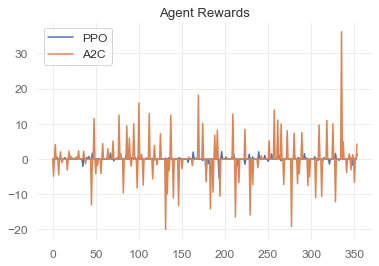

In [47]:
ModelCreation()

In [ ]:
qs.extend_pandas()
for i in envs:
    net_worth = pd.Series(env.history['total_profit'], index=data.index[start_index+1:end_index])
    returns = net_worth.pct_change().iloc[1:]

    qs.reports.full(returns)